In [7]:
# Module imports
import qexpy as q
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bokeh.io import output_notebook
output_notebook(hide_banner=True)

In [8]:
monochromator_offset = q.Measurement(283, 1, units='nm')
calibration = monochromator_offset - 589.2 
print("Calibration offset", calibration)

lambda_c = 1130
lambda_p = 200
print("Spectral range {} nm  to {} nm"
      .format(lambda_c - lambda_p - 100, lambda_c + lambda_p))

print("Monochromator range {} nm to {} nm"
      .format(lambda_c - lambda_p + calibration - 100, lambda_c + lambda_p + calibration))

Calibration offset -306 +/- 1
Spectral range 830 nm  to 1330 nm
Monochromator range 524 +/- 1 nm to 1024 +/- 1 nm


<IPython.core.display.Javascript object>


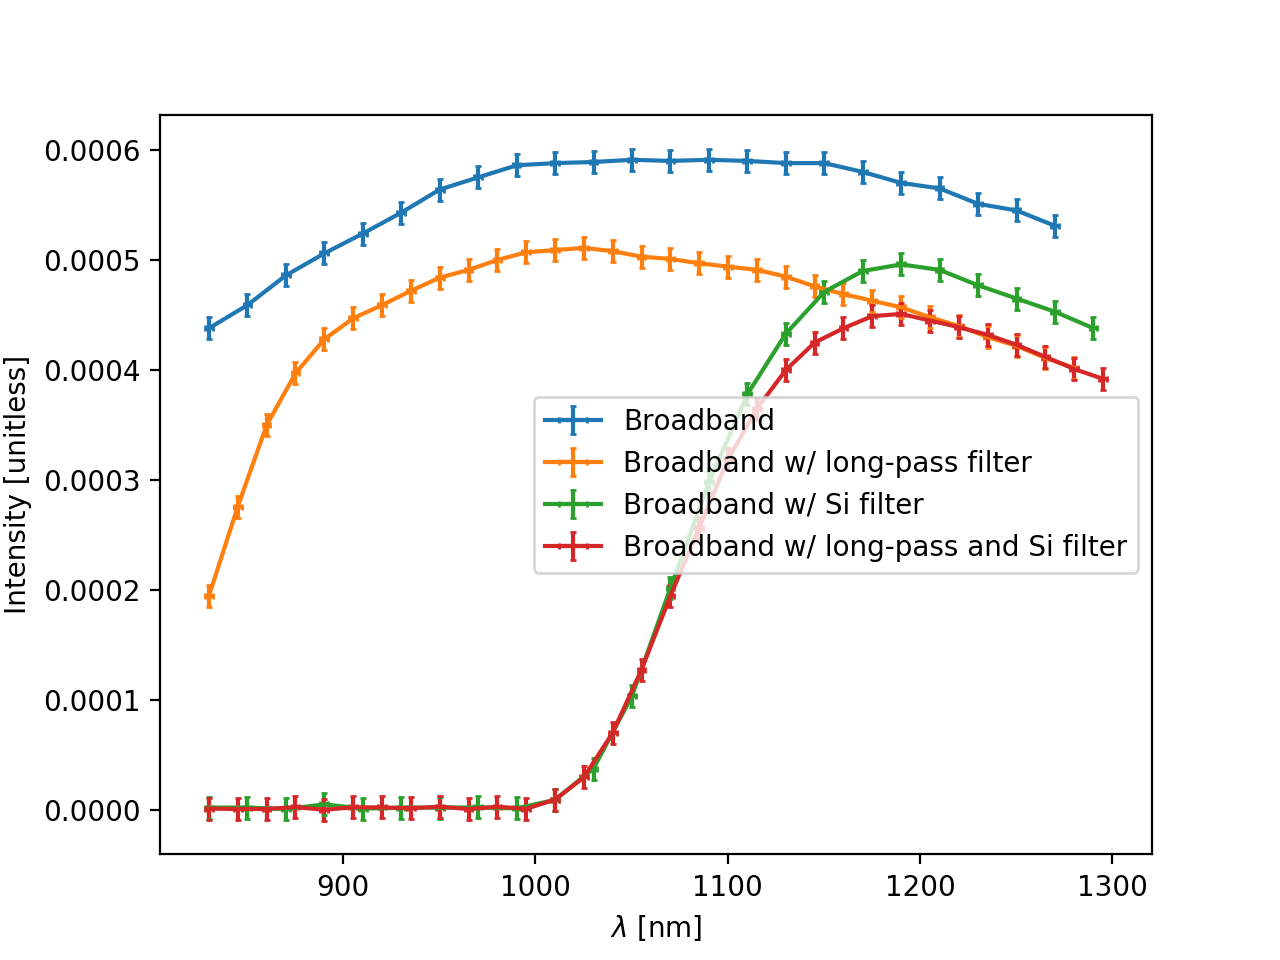

In [292]:
df_si = pd.read_csv(
    './data/spectral_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])
df_py = pd.read_csv(
    './data/spectral_response_broad_pyro.csv',
    header=None,
    names=['lambda', 'intensity'])
df_long = pd.read_csv(
    './data/spectral_long_pass_more_points.csv',
    header=None, 
    names=['lambda', 'intensity'])
df_long_si = pd.read_csv(
    './data/spectral_silicon_long_pass_more_points.csv',
    header=None,
    names=['lambda', 'intensity'])

plt.figure()
plt.errorbar(
    df_py['lambda'] - calibration.mean,
    df_py['intensity'],
    xerr=2*np.ones_like(df_py['lambda']),
    yerr=1e-5*np.ones_like(df_py['lambda']),
    capsize=1,
    label="Broadband")
plt.errorbar(
    df_long['lambda'] - calibration.mean,
    df_long['intensity'],
    xerr=2*np.ones_like(df_long['lambda']),
    yerr=1e-5*np.ones_like(df_long['lambda']),
    capsize=1,
    label="Broadband w/ long-pass filter")
plt.errorbar(
    df_si['lambda'] - calibration.mean,
    df_si['intensity'],
    xerr=2*np.ones_like(df_si['lambda']),
    yerr=1e-5*np.ones_like(df_si['lambda']),
    capsize=1,
    label="Broadband w/ Si filter")
plt.errorbar(
    df_long_si['lambda'] - calibration.mean,
    df_long_si['intensity'],
    xerr=2*np.ones_like(df_long_si['lambda']),
    yerr=1e-5*np.ones_like( df_long_si['lambda']),
    capsize=1,
    label="Broadband w/ long-pass and Si filter")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

#### Analysis

We performed a simple curve fit on the ratio of the the broadband w/ LPF and broadband w/ LPF & Si filters. With simple fitting, we were able to achieve an average Si bandgap of 1.1 eV.

<IPython.core.display.Javascript object>


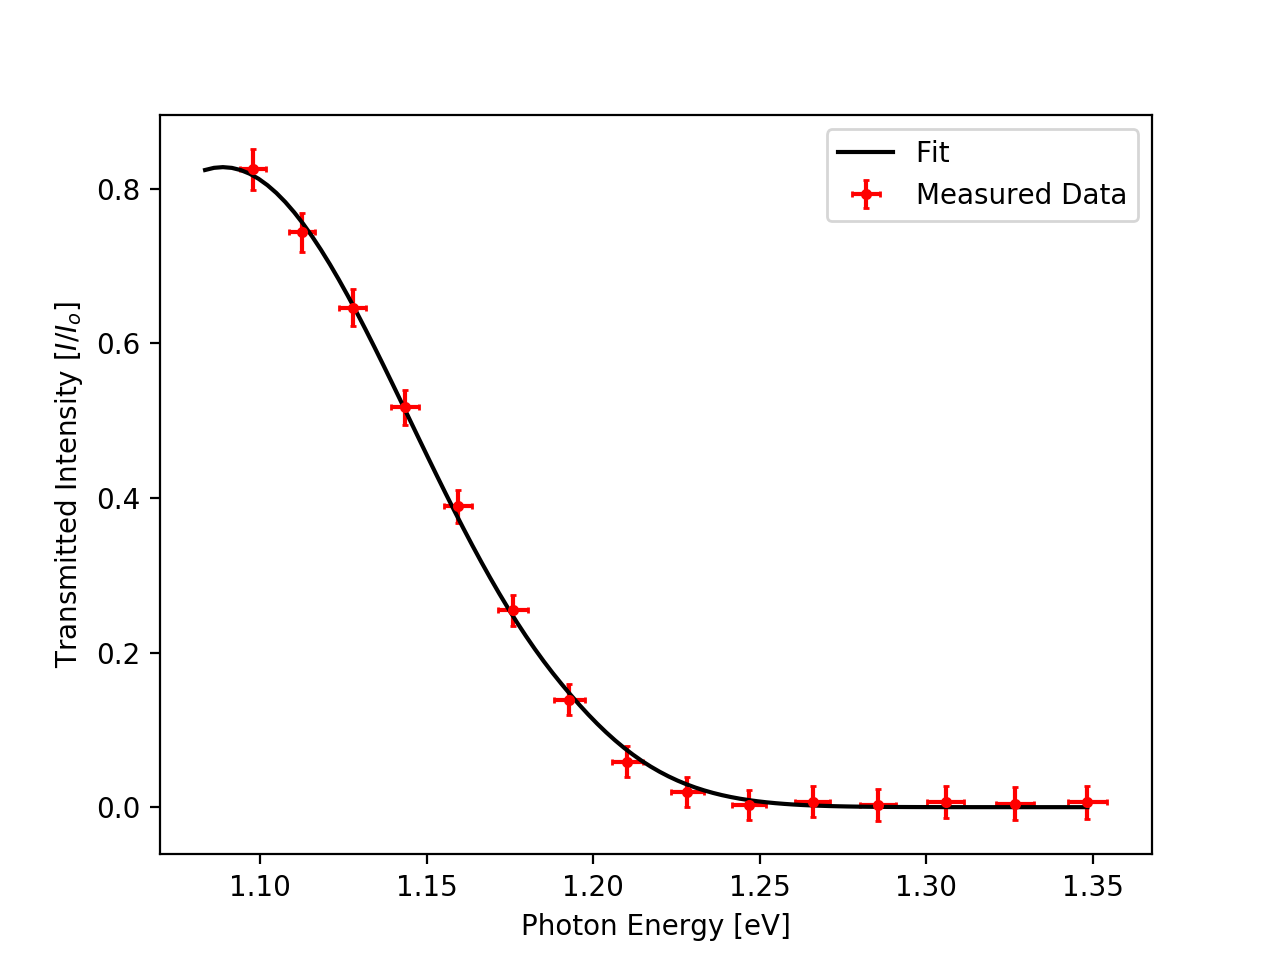

Fit parameters: (R, C, Eg)
R: 0.09018777596834794 +/- 0.007646689008632445
C: 3.0800861939723005 +/- 0.19523988933711106
Eg: 1.1387950339156827 +/- 0.0029037898493766033


In [293]:
h = 4.136e-15 # eV s
c = 3e17 # nm/s
R = 0.3 
x = 1/1000 # mm

def transmittance(Eph, R, C, Eg):
    Ep = 0.050
    kB = 8.617 # eV / K
    T = 300 # K
    x = 1/1000 # m
    # low alpha
    alpha_low = (Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1)
    # High alpha
    alpha_high =(Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1) + \
                (Eph - Eg - Ep)**2 / (1 - np.exp(-Ep/(kB*T)))
    alpha = np.where(Eph > Ep + Eg, alpha_high, alpha_low)
    return (1 - R) ** 2 * np.exp(-C * alpha * x)


Io = q.MeasurementArray(df_long['intensity'].values, 1e-5)
I = q.MeasurementArray(df_long_si['intensity'][:-1].values, 1e-5)
I_Io = I / Io
wavelengths = q.MeasurementArray(
    (df_long['lambda'] - calibration.mean).values, 4)
energy = h * c / wavelengths

# Curve fitting for phonon assisted absorption
tStart = 6
tEnd = 21
t_popt, t_pcov = \
    curve_fit(transmittance, 
              xdata=energy.means[tStart:tEnd],
              ydata=I_Io.means[tStart:tEnd],
              p0=np.array([0.1, 1, 1.1]))
# Plotting
plt.figure()
energyFit = np.linspace(energy.means[tStart], energy.means[tEnd], 100)
transmittance_fit = transmittance(energyFit, t_popt[0], t_popt[1], t_popt[2])
plt.errorbar(energy.means[tStart:tEnd], 
             I_Io.means[tStart:tEnd],
             xerr=energy.stds[tStart:tEnd],
             yerr=I_Io.stds[tStart:tEnd],
             fmt='.',
             capsize=1,
             color='red',
             label="Measured Data")
plt.plot(energyFit, 
         transmittance_fit,
         label="Fit",
         color='black')

plt.xlabel("Photon Energy [eV]")
plt.ylabel("Transmitted Intensity [$I/I_o$]")
plt.legend()

R_fit, C_fit, Eg_fit = t_popt
R_err, C_err, Eg_err = np.sqrt(np.diag(t_pcov))
print("Fit parameters: (R, C, Eg)")
print("R: {} +/- {}".format(R_fit, R_err))
print("C: {} +/- {}".format(C_fit, C_err))
print("Eg: {} +/- {}".format(Eg_fit, Eg_err))

<IPython.core.display.Javascript object>


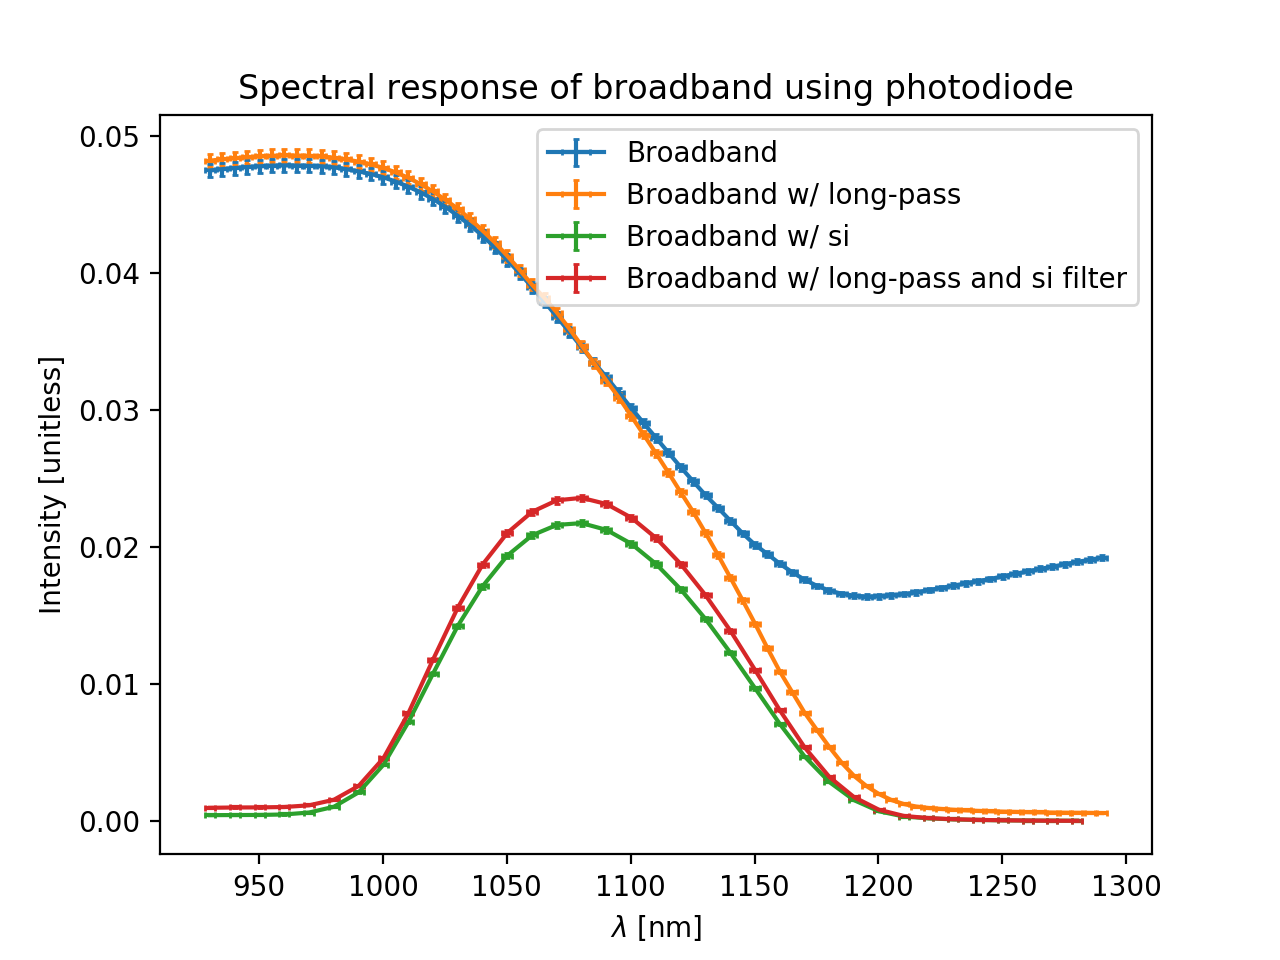

In [295]:
df_diode = pd.read_csv(
    './data/second_experiment_first_collection.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long = pd.read_csv(
    './data/second_experiment_long_pass_second_run.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_si = pd.read_csv(
    './data/second_experiment_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long_si = pd.read_csv(
    './data/second_experiment_silicon_long_pass.csv',
    header=None,
    names=['lambda', 'intensity'])
    
    
plt.figure()
plt.errorbar(
    df_diode['lambda'] - calibration.mean,
    df_diode['intensity'],
    xerr=2*np.ones_like(df_diode['lambda']),
    yerr=0.01*df_diode['intensity'],
    capsize=1,
    label="Broadband")
plt.errorbar(
    df_diode_long['lambda'] - calibration.mean,
    df_diode_long['intensity'],
    xerr=2*np.ones_like(df_diode_long['lambda']),
    yerr=0.01*df_diode_long['intensity'],
    capsize=1,
    label="Broadband w/ long-pass")
plt.errorbar(
    df_diode_si['lambda'] - calibration.mean,
    df_diode_si['intensity'],
    xerr=2*np.ones_like(df_diode_si['lambda']),
    yerr=0.01*df_diode_si['intensity'],
    capsize=1,
    label="Broadband w/ si")
plt.errorbar(
    df_diode_long_si['lambda'] - calibration.mean,
    df_diode_long_si['intensity'],
    xerr=2*np.ones_like(df_diode_long_si['lambda']),
    yerr=0.01*df_diode_long_si['intensity'],
    capsize=1,
    label="Broadband w/ long-pass and si filter")

plt.title("Spectral response of broadband using photodiode")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

<IPython.core.display.Javascript object>


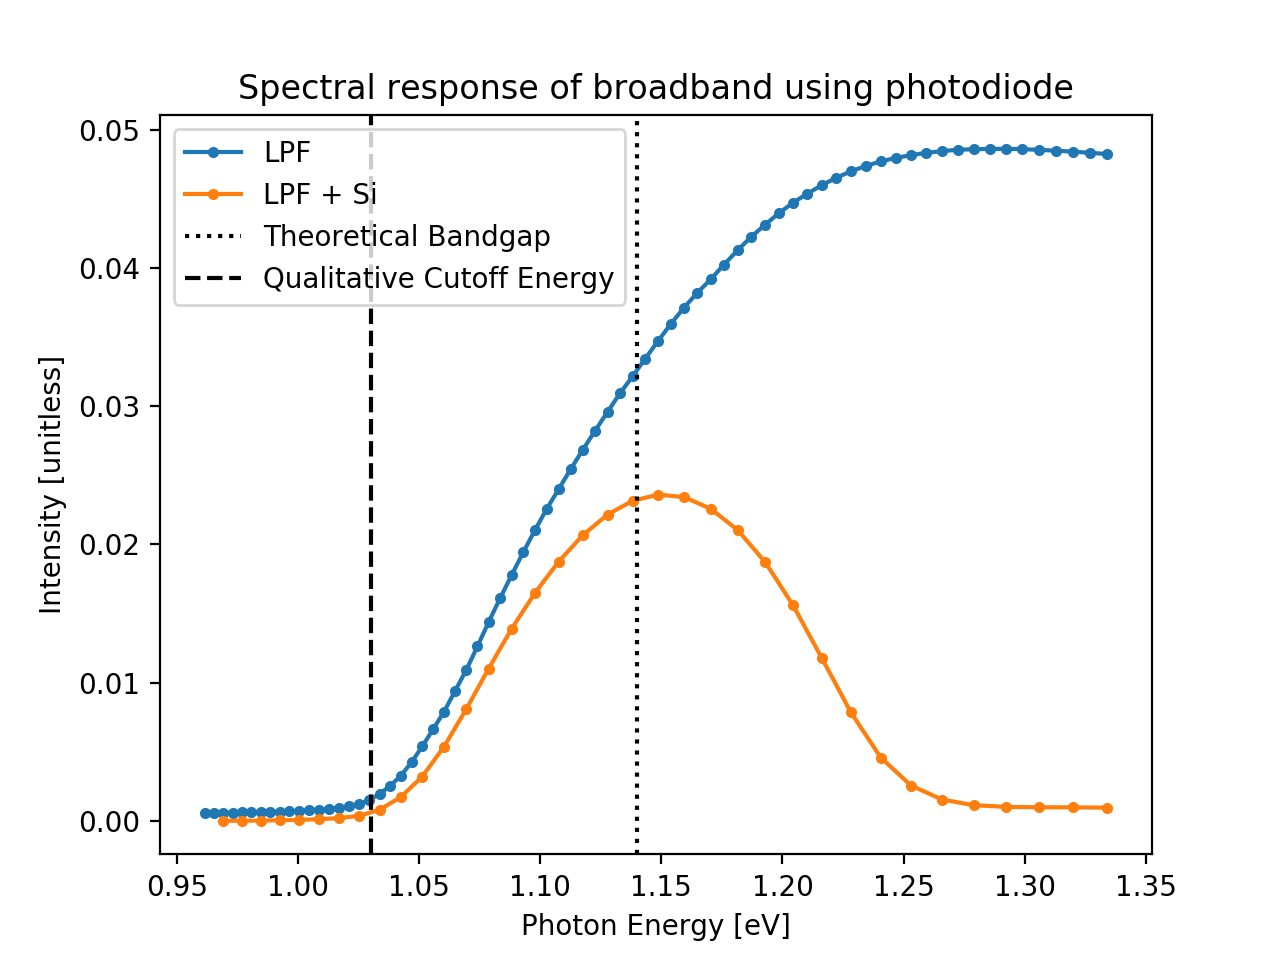

In [306]:
plt.figure()
plt.plot(
    h*c/(df_diode_long['lambda'] - calibration.mean),
    df_diode_long['intensity'],
    '.-',
    label="LPF")
plt.plot(
    h*c/(df_diode_long_si['lambda'] - calibration.mean),
    df_diode_long_si['intensity'],
    '.-',
    label="LPF + Si")

plt.axvline(x=1.14, 
            color='black',
            label="Theoretical Bandgap",
            linestyle=':')
plt.axvline(x=1.03, 
            color='black',
            label="Qualitative Cutoff Energy",
            linestyle='--')

plt.title("Spectral response of broadband using photodiode")
plt.xlabel("Photon Energy [eV]")
plt.ylabel("Intensity [unitless]")
plt.legend(loc='best')

### Bandgap Measurement by Resistivity

#### Apparatus
Our apparatus came presetup. We have a computer running Windows XP which is connected to a Keithly 2010 temperature sensor. A thermocouple is connected to the Keithly, whose parallel connects are connected to a cold junction. The silicon sample itself is connected to a four point probe with a Keithly 2400-LV current source. We spent some time understanding out apparatus and how it works. We were able to turn on the oven and have the temperature updated on the thermocouple, albiet without the cold junction.

![heat_diagram](data/app3diagram.png)

#### Experiemental setup
We first put the thermocouple in an icebath with distilled water. We used the front panel temperature, a reading of $0.5$ celsius to calibrate the actual temperature of $0$ celsius. We used a current of 105 micro amps.

#### Initial Results
This was our hystersis plot:

<IPython.core.display.Javascript object>


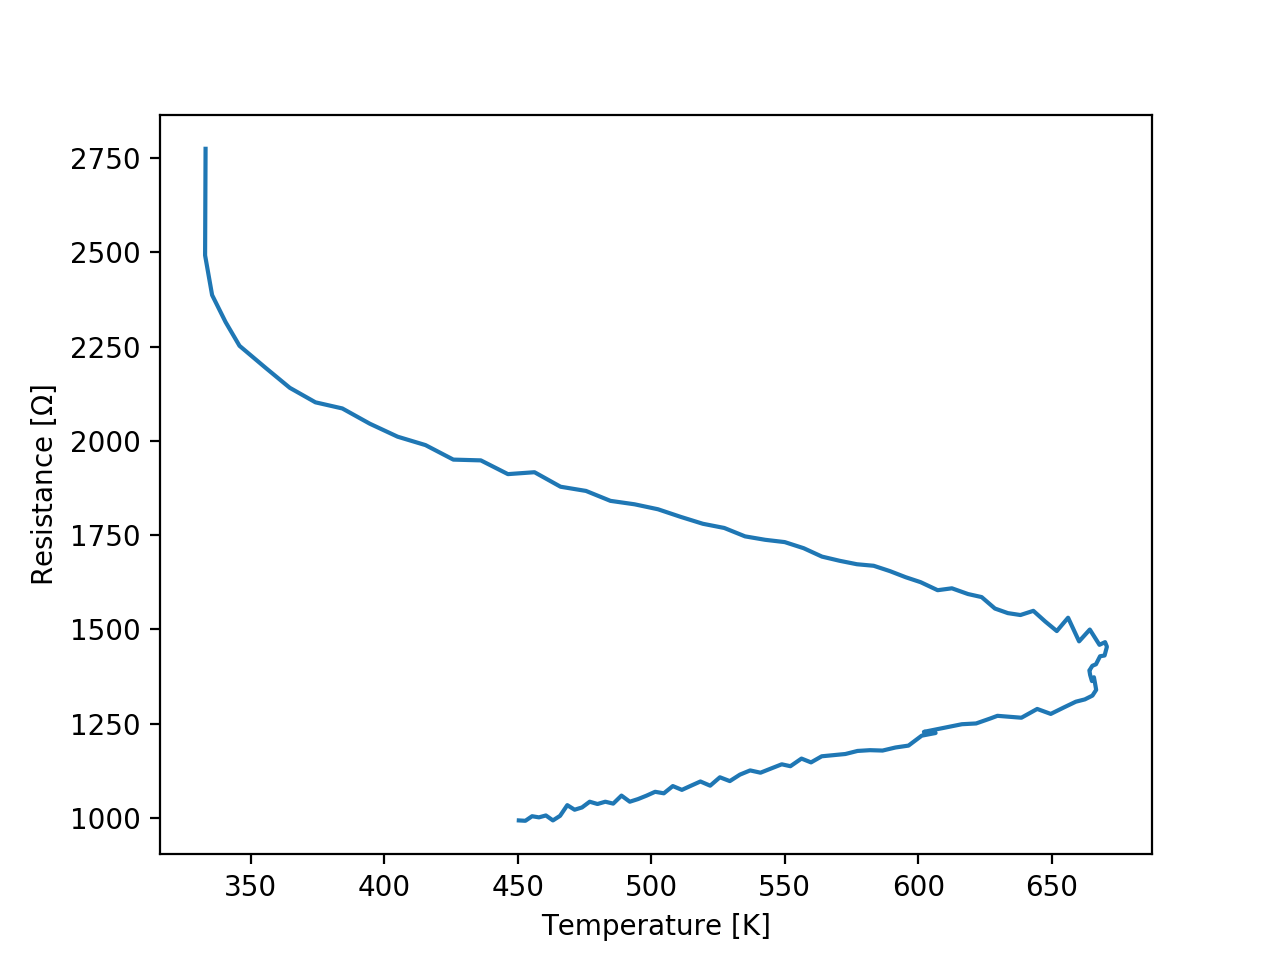

In [11]:
df_temp = pd.read_csv('./data/experiemnt3_0.csv', sep='\t')

plt.figure()
plt.plot(df_temp["Temperature"], df_temp["Resistance"])
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

We repeated this experiment many times, since no curve fits seemed to fit our original curve. We noticed that our data was mostly exponential at first, but at high temperatures, we observed a massive jump in resistance. We atrribute this to melding solder, since we were beyond the melting point of 400 celsius. Therefore, our fit will only be done on the expoentnial part of the data.

The following graphs were the exponetial areas that were extracted from the data collection.

In [ ]:
def R(T, Eg, A):
    kb = 8.617e-5
    ue = 739343109.3882 * T**(-2.3096)
    uh = 177871187.4661 * T**(-2.25)
    Eg_T = Eg * 
    
    return A * np.exp(Eg/(2 * kb * T))/((ue + uh)* T**(3/2))


<IPython.core.display.Javascript object>


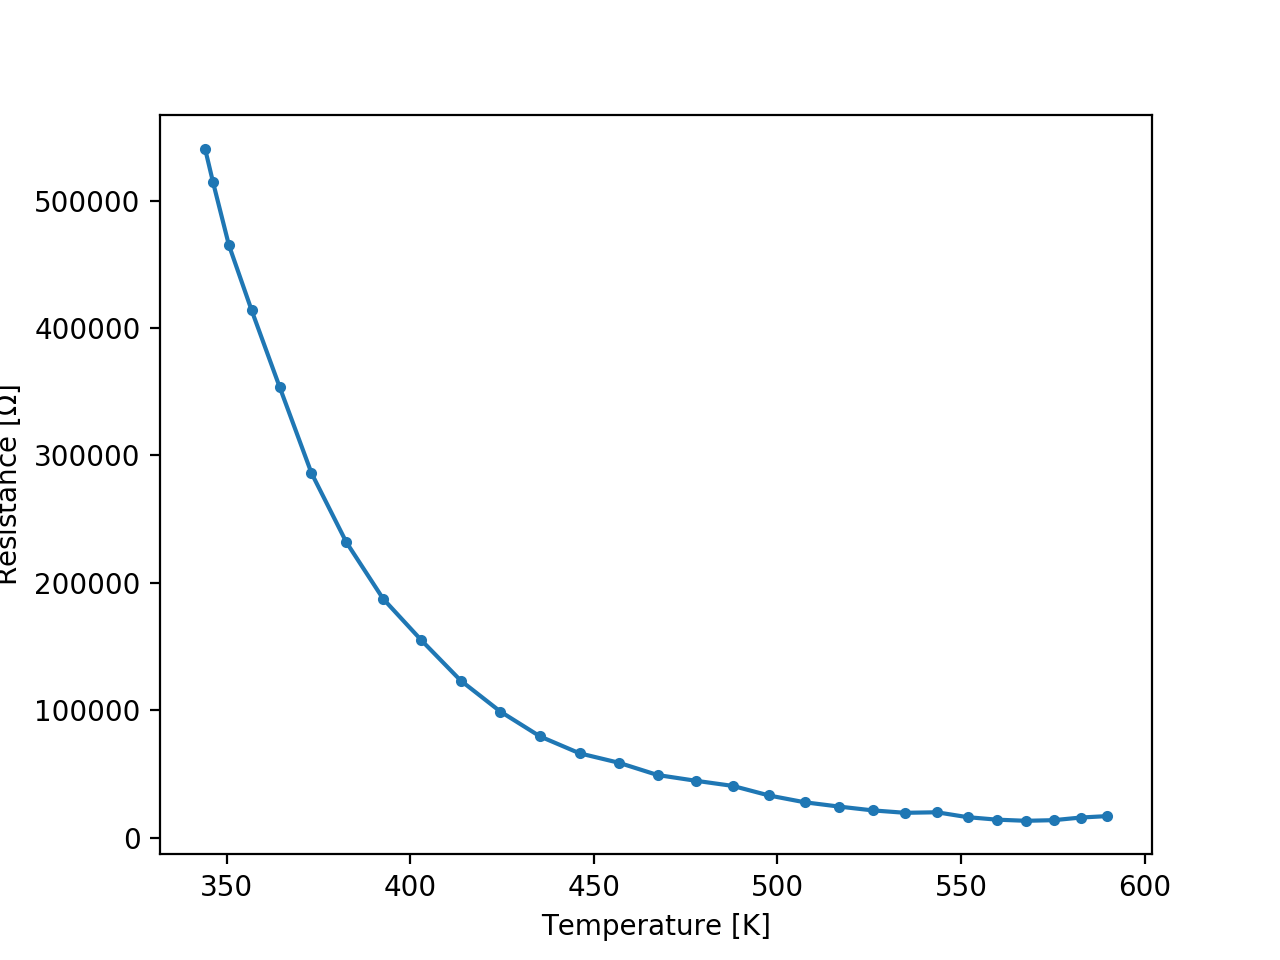

In [12]:
df_temp1 = pd.read_csv('./data/experiment3_1.csv', sep='\t')

startIndex = 0
endIndex = 29
temperature = df_temp1["Temperature"][startIndex:endIndex]
resistance = df_temp1["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

<IPython.core.display.Javascript object>


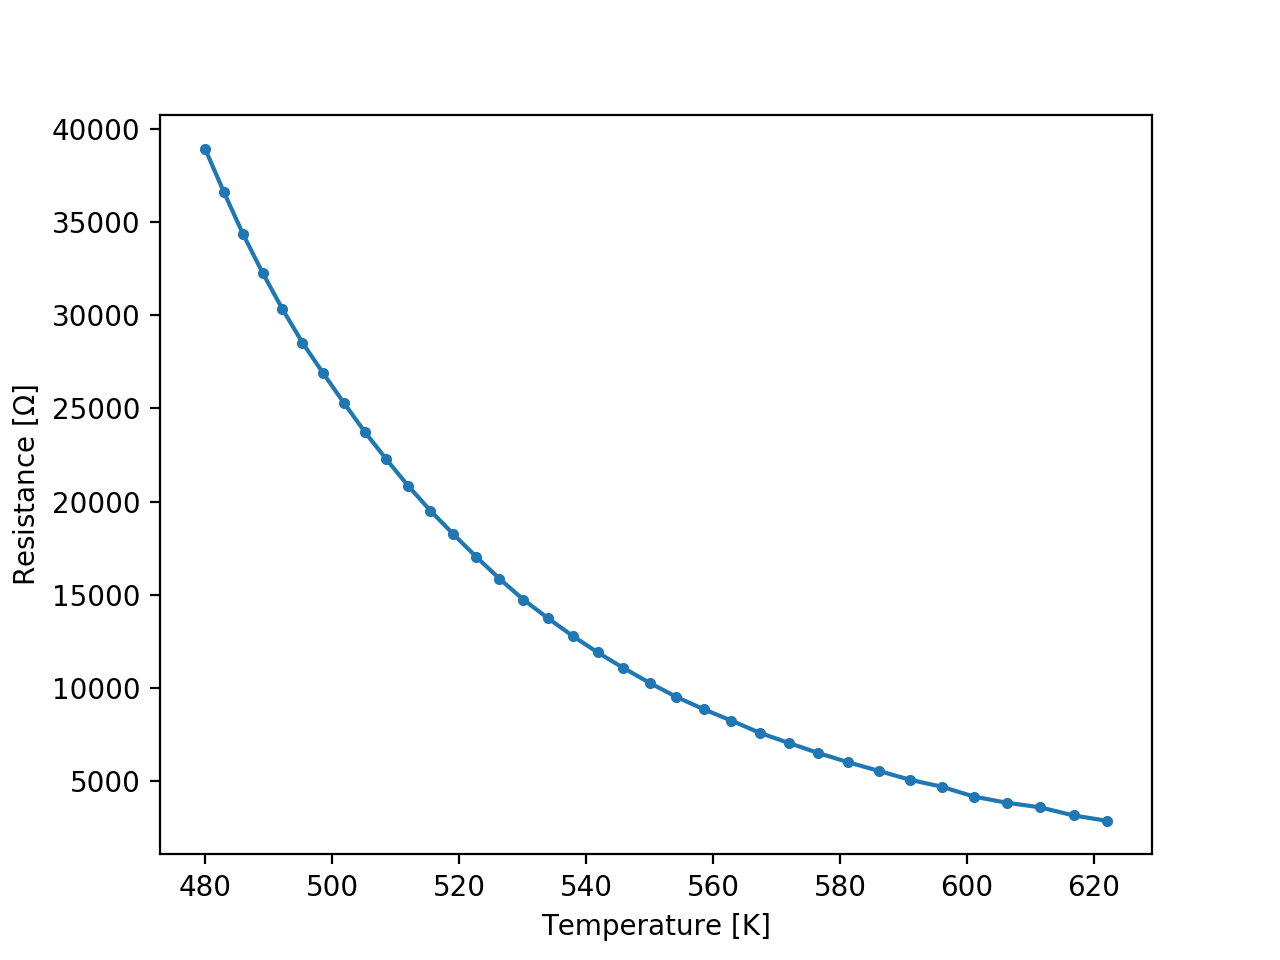

In [14]:
df_temp2 = pd.read_csv('./data/experiment3_2.csv', sep='\t')

startIndex = 47
endIndex = -1
temperature = df_temp2["Temperature"][startIndex:endIndex]
resistance = df_temp2["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

<IPython.core.display.Javascript object>


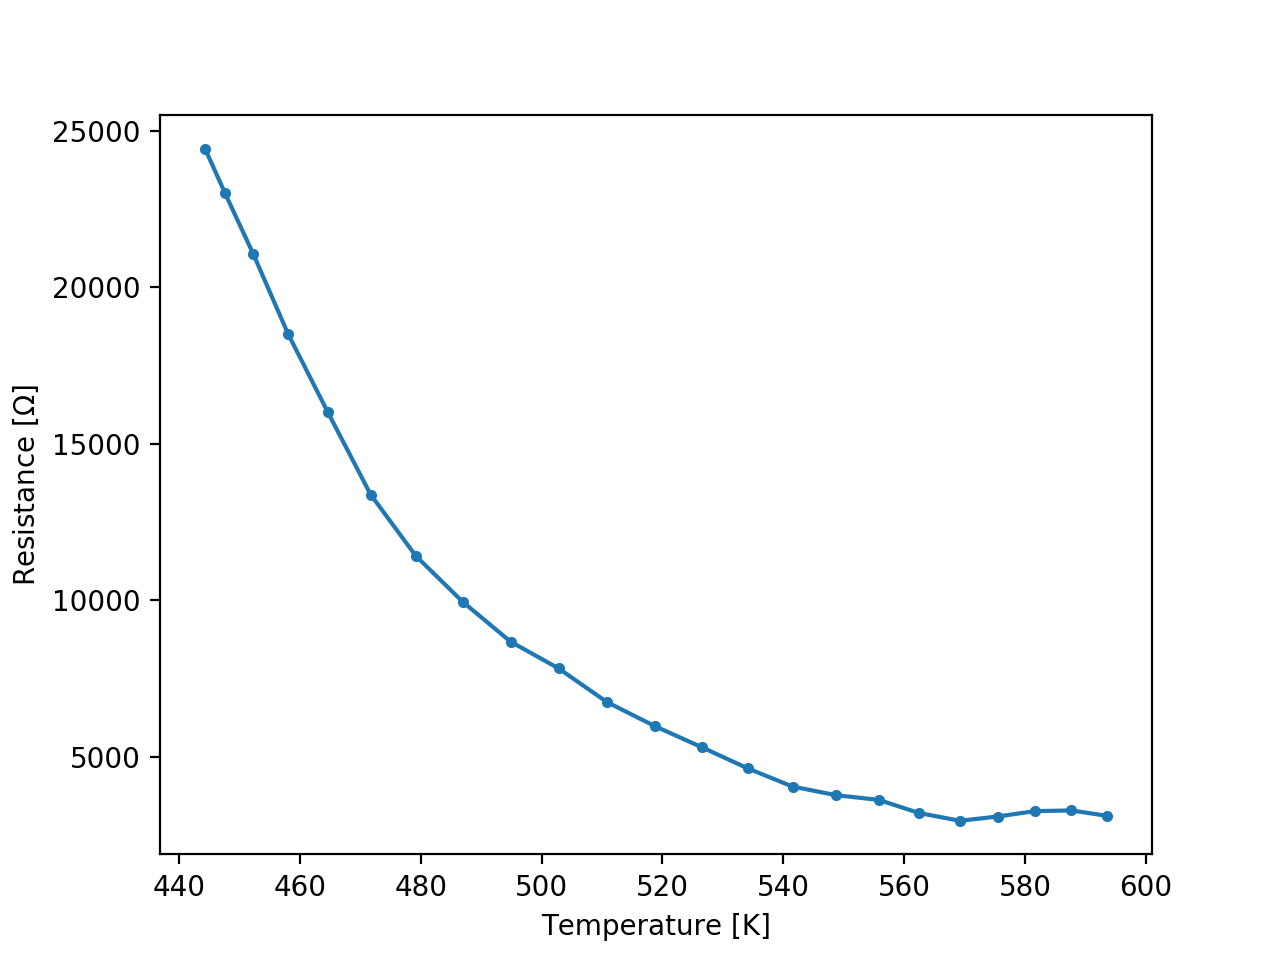

In [15]:
df_temp3 = pd.read_csv('./data/experiment3_3.csv', sep='\t')

startIndex = 0
endIndex = 23
temperature = df_temp3["Temperature"][startIndex:endIndex]
resistance = df_temp3["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")